## Predicting Crashes in Financial Markets - RNN LSTM
- Model: RNN LSTM (stateful)
- Response variable: Crash within 1, 3 and 6 months (0: no, 1: yes)
- Crash definition: Drawdown in 99.5% quantile
- Sequence: price changes over past 5 trading days

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn import metrics
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
os.chdir('D:\Major Project\Predicting-Stock-Market-Crashes\models')
from prepare_data_RNN import DataLoader
from evaluate_results import EvaluateResults

In [42]:
# -------------------- data preparation -------------------- #
os.chdir('D:\Major Project\Predicting-Stock-Market-Crashes\indiandata')
datasets_original = ['niftyIT.csv', 'niftyauto.csv', 'niftybank.csv','niftyInfra.csv', 'niftymetal.csv']
dataset_names = ['niftyIT', 'niftyAuto', 'niftybank', 'niftyInfra', 'niftymetal']

data = DataLoader(datasets_original, dataset_names)

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
# crashes according to Jacobsson:
# specify drawdown thresholds for crashes (determined in exploration.ipynb):
# crashes according to Jacobsson:
crash_thresholds = [-0.104603, -0.106839, -0.106803, -0.106195, -0.084650]
# crashes according to Sornette:
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264]
# crashes according to Sornette:
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264]
datasets_revised, crashes = data.get_data_revised(crash_thresholds)

months = [1, 3, 6]      # <-- predict if crash n months ahead
sequence = 5            # <-- number of days lookback as input(only if select_features=False)
additional_feat = False # <-- add mean price change and vol for 4 time widnows over 252 days
batch_size = 60         # <-- batch size needs to be specified to satisfy stateful=True
dfs_x1, dfs_x2, dfs_y = data.get_df_xy(months=months, sequence=sequence, \
                            batch_size=batch_size, additional_feat=additional_feat)

In [43]:
# -------------------- RNN LSTM model -------------------- #
model_name = 'RNN LSTM'
neurons = 50
dropout = 0
optimizer = 'adam'
loss = 'binary_crossentropy'
activation = 'sigmoid'
stateful = True
inp_dim = 1   # <-- 1 if price change only, 2 if volatility as well
inp_tsteps = sequence + 4 * additional_feat
def rnn_lstm(inp_tsteps, inp_dim, neurons, dropout):
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, inp_tsteps, inp_dim), \
            stateful=stateful, return_sequences=True))
    model.add(LSTM(neurons, stateful=stateful, return_sequences=False))
    model.add(Dense(3, activation=activation))
    return model
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (60, 5, 50)               10400     
_________________________________________________________________
lstm_50 (LSTM)               (60, 50)                  20200     
_________________________________________________________________
dense_25 (Dense)             (60, 3)                   153       
Total params: 30,753
Trainable params: 30,753
Non-trainable params: 0
_________________________________________________________________


In [44]:
# -------------------- Train and test RNN LSTM model -------------------- #
epochs = 40
test_data = 'niftymetal'
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x1_training = list(dfs_x1)
dfs_x1_training.pop(index_test)
dfs_x2_training = list(dfs_x1)
dfs_x2_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
os.chdir('D:\Major Project\Predicting-Stock-Market-Crashes\models\indian_model_weights')

for val_data in training_set_names:
    model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=1, dropout=dropout)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
    print('Train ' + str(model_name) + ' - val data: ' + str(val_data))
    for e in range(epochs):
        np_train_x_l, _, np_train_y_l = data.get_train_stateful(dfs_x1_training, dfs_x2_training,\
            dfs_y_training, training_set_names, test_data=val_data)
        i = 0
        for np_tr_x, np_tr_y in zip(np_train_x_l, np_train_y_l):
            i += 1
            x_tr = np.expand_dims(np_tr_x, axis=2)
            y_tr = np_tr_y.astype(int)
            model.fit(x_tr, y_tr, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
            model.reset_states()
            if (e + 1) % 10 == 0 and i == len(np_train_x_l):
                model.save_weights('stateful_all_{0}_{1}.hdf5'.format(val_data, e + 1))

Train RNN LSTM - val data: niftyIT
Train RNN LSTM - val data: niftyAuto
Train RNN LSTM - val data: niftybank
Train RNN LSTM - val data: niftyInfra


In [45]:
# -------------------- Load weights and predict results -------------------- #
os.chdir('D:\Major Project\Predicting-Stock-Market-Crashes\models\indian_model_weights')
epoch = 40 # <-- change to load model weights from previous epochs
y_train_all, y_val_all = [], []
y_pred_train_all, y_pred_val_all = [], []
for val_data in training_set_names:
    np_x_train, _, np_y_train, np_x_val, _, np_y_val = \
        data.get_train_test(dfs_x1_training, dfs_x2_training, dfs_y_training, \
                training_set_names, test_data=val_data)
    y_train_all.append(np_y_train)
    y_val_all.append(np_y_val)
    model.load_weights('stateful_all_{0}_{1}.hdf5'.format(val_data, epoch))
    y_pred_train = model.predict(np_x_train, batch_size=batch_size, verbose=True) 
    y_pred_train_all.append(y_pred_train)
    y_pred_val = model.predict(np_x_val, batch_size=batch_size, verbose=True)
    y_pred_val_all.append(y_pred_val)

1320/1320 [==============================] - 0s 29us/step


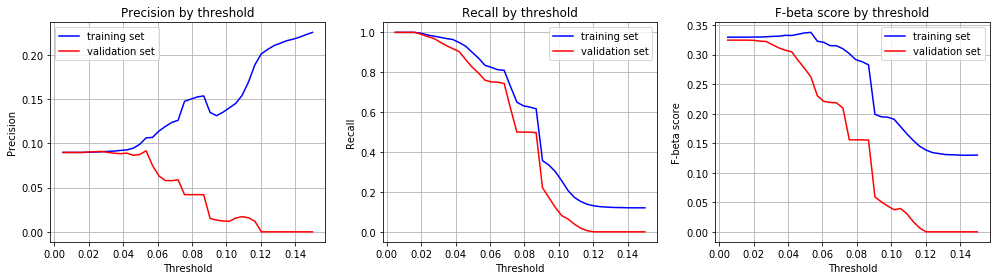

In [46]:
# -------------------- Find best threshold -------------------- #
month_prediction = 6
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
y_train_all_ = [y[:, index_month] for y in y_train_all]
y_val_all_ = [y[:, index_month] for y in y_val_all]
y_pred_train_all_ = [y[:, index_month] for y in y_pred_train_all]
y_pred_val_all_ = [y[:, index_month] for y in y_pred_val_all]
beta = 2
rcParams['figure.figsize'] = 14, 4
eval_ = EvaluateResults(y_train_all_, y_val_all_, y_pred_train_all_, y_pred_val_all_, model_name, test_data)
eval_.find_threshold(beta=beta, threshold_min=0.005, threshold_max=0.15, resolution=40)

In [47]:
# -------------------- Evaluate results -------------------- #
threshold = 0.07
beta = 2
print(model_name)
print('\n')
print('Predict crash in:               ' + str(month_prediction) + ' months')
print('Threshold for positives:        ' + str(threshold))
print('Number of features:             ' + str(dfs_x1[0].shape[1] + dfs_x2[0].shape[1]))
print('Number of rows in training set: ' + str(len(y_pred_train_all[0]) + len(y_pred_val_all[0])))
print('Number of epochs:               ' + str(epoch))
print('Sequence length:                ' + str(sequence))
print('Number of neurons/layer:        ' + str(neurons))
print('Batch size:                     ' + str(batch_size))
print('Optimizer:                      ' + str(optimizer))
print('Loss function:                  ' + str(loss))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

RNN LSTM


Predict crash in:               6 months
Threshold for positives:        0.07
Number of features:             10
Number of rows in training set: 5280
Number of epochs:               40
Sequence length:                5
Number of neurons/layer:        50
Batch size:                     60
Optimizer:                      adam
Loss function:                  binary_crossentropy


Results for each train/val split:
                       niftyIT  niftyAuto  niftybank  niftyInfra
positive actual train     0.09       0.10       0.10        0.08
positive pred train       1.00       0.92       1.00        0.08
precision train           0.09       0.10       0.10        0.21
recall train              1.00       0.94       1.00        0.23
accuracy_train            0.09       0.16       0.10        0.87
score_fbeta train         0.32       0.35       0.35        0.22
positive actual val       0.10       0.06       0.07        0.13
positive pred val         1.00       0.90       1.00   

In [48]:
# -------------------- Train model on all training data for testing -------------------- #
epochs = 40
test_data = 'niftymetal'
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
os.chdir('D:\Major Project\Predicting-Stock-Market-Crashes\models\indian_model_weights')

#for val_data in training_set_names:
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=1, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
print('Train model for testing ' + str(model_name))
for e in range(epochs):
    np_train_x_l, _, np_train_y_l = data.get_train_stateful(dfs_x1, dfs_x2,\
        dfs_y, dataset_names, test_data=test_data)
    i = 0
    for np_tr_x, np_tr_y in zip(np_train_x_l, np_train_y_l):
        i += 1
        x_tr = np.expand_dims(np_tr_x, axis=2)
        y_tr = np_tr_y.astype(int)
        model.fit(x_tr, y_tr, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        if (e + 1) % 5 == 0 and i == len(np_train_x_l):
            model.save_weights('stateful_final_{0}_{1}.hdf5'.format(test_data, e + 1))

Train model for testing RNN LSTM


In [49]:
# -------------------- Test model -------------------- #
test_data = 'niftymetal'
epoch = 40
threshold = 0.07
month_prediction = 1   # <-- predict crash in 1, 3 or 6 months
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
_, _, _, np_x1_test, _, np_y_test = \
    data.get_train_test(dfs_x1, dfs_x2, dfs_y, dataset_names, test_data=test_data)
#np_x_test = np.concatenate([np_x1_test, np_x2_test], axis=2)
model.load_weights('stateful_final_{0}_{1}.hdf5'.format(test_data, epoch))
y_pred_test = model.predict(np_x1_test, batch_size=batch_size)[:, index_month]
y_test = np_y_test[:, index_month]
y_pred_test_bin = eval_.test_results(y_test, y_pred_test, threshold, beta=beta)

Test results (test set: niftybank):
Positive test cases actual:         0.07
Positive test cases predicted:      0.0
Precision test (model/random):      0.0 / 0.07
Recall test (model/random):         0.0 / 0.0
Accuracy test (model/random):       0.92 / 0.92
Score test fbeta:                   0.0 / 0.0


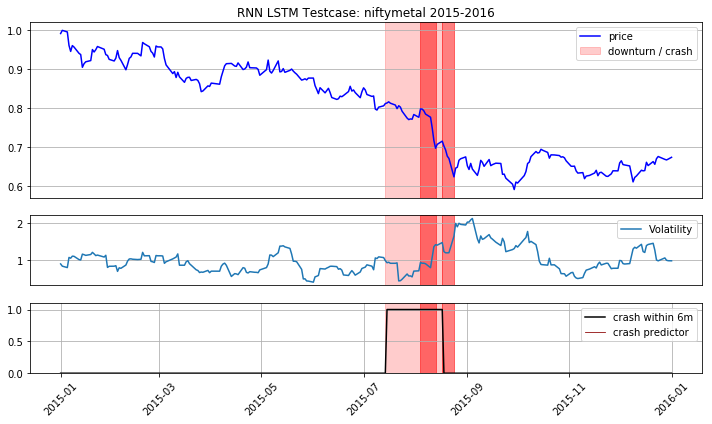

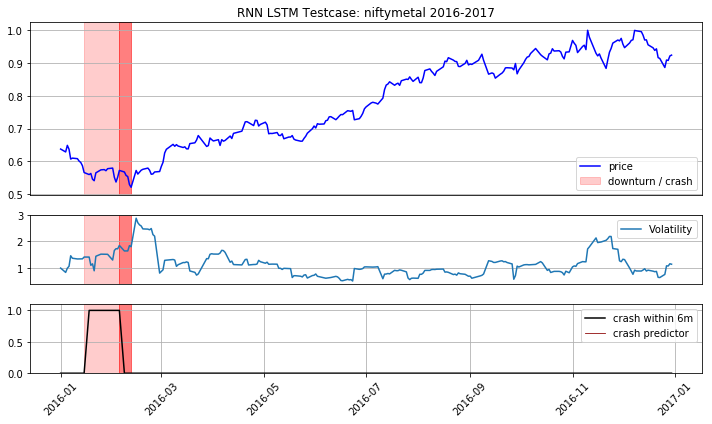

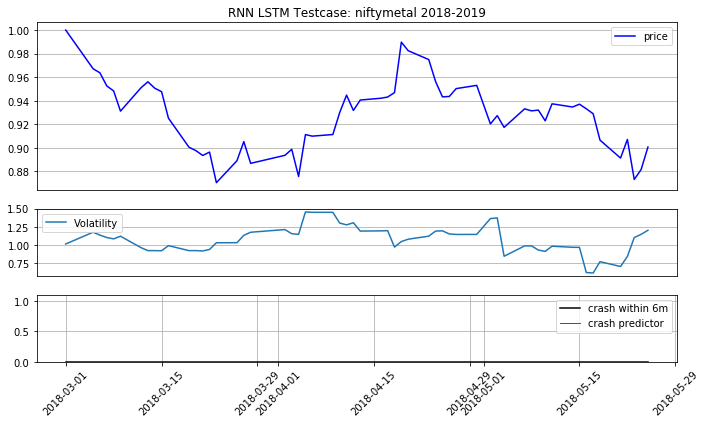

In [50]:
# -------------------- Plot test results -------------------- #
df = datasets_revised[index_test].reindex(dfs_x1[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = [ '2015-01-01','2016-01-01','2018-03-01']
t_end = [ '2016-01-01','2017-01-01','2019-03-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)